 # Notebook for Downloading ds084.1 Data.

#### Start by downloading some sample data

In [1]:
import sys, os
import requests

 #### Since RDA requires authentication to access data, the following code blocks will start this process.

In [2]:
# Compatibility for python2 and getpass not installed
try:
    import getpass
    input = getpass.getpass
except:
    try:
        input = raw_input
    except:
        pass

#### Now, we need your RDA email (username) and password.

In [3]:
pswd = input('password: ')
email = 'jianyu.liang@riken.jp'

password: ········


In [4]:
values = {'email' : email, 'passwd' : pswd, 'action' : 'login'}
login_url = 'https://rda.ucar.edu/cgi-bin/login'

In [5]:
ret = requests.post(login_url, data=values)
if ret.status_code != 200:
    print('Bad Authentication')
    print(ret.text)
    exit(1)

In [25]:
dspath = 'https://rda.ucar.edu/data/ds084.1/'
filelist = ['2022/20220917/gfs.0p25.2022091712.f000.grib2', 
            '2022/20220917/gfs.0p25.2022091712.f012.grib2',
            '2022/20220917/gfs.0p25.2022091712.f024.grib2', 
            '2022/20220917/gfs.0p25.2022091712.f048.grib2']

Change this if you want your files saved somewhere other than the current directory 

In [26]:
save_dir = './'
print(filelist)

['2022/20220917/gfs.0p25.2022091712.f000.grib2', '2022/20220917/gfs.0p25.2022091712.f012.grib2', '2022/20220917/gfs.0p25.2022091712.f024.grib2', '2022/20220917/gfs.0p25.2022091712.f048.grib2']


 #### Now to download the files

In [27]:
for file in filelist:
    filename = dspath + file
    outfile = save_dir + os.path.basename(filename)
    print('Downloading', file)
    req = requests.get(filename, cookies = ret.cookies, allow_redirects=True)
    open(outfile, 'wb').write(req.content)

### Once the data has been downloaded, you can begin to plotting.

In order to plot this data, you may need to install libraries. The easiest way to do this is to use conda, however any method of getting the following libraries will work.

In [29]:
import xarray # used for reading the data.
import matplotlib.pyplot as plt # used to plot the data.
import ipywidgets as widgets # For ease in selecting variables.
import cartopy.crs as ccrs # Used to georeference data.
import numpy as np

In [30]:
filelist_arr = [save_dir + os.path.basename(file) for file in filelist]
selected_file = widgets.Dropdown(options=filelist_arr, description='data file')
display(selected_file)

Dropdown(description='data file', options=('./gfs.0p25.2022091712.f000.grib2', './gfs.0p25.2022091712.f012.gri…

In [22]:
# xarray.open_dataset(selected_file.value)  will print out error message containing the levels. select the one you want

# detail description of the variables can be found at 
# https://rda.ucar.edu/datasets/ds084.1/index.html#metadata/detailed.html?_do=y&view=level

In [31]:
# Now to load in the data to xarray
ds = xarray.open_dataset(selected_file.value, filter_by_keys={ 'typeOfLevel': 'meanSea'})

In [32]:
# Helper methods# Define function to get standard dimensions
def get_time(dataset):
    for _, cur_coord in dataset.coords.items():
        if cur_coord.attrs.get('standard_name') == 'time':
            return cur_coord
def get_lat(dataset):
    for _, cur_coord in dataset.coords.items():
        if cur_coord.attrs.get('standard_name') == 'latitude':
            return cur_coord
def get_lon(dataset):
    for _, cur_coord in dataset.coords.items():
        if cur_coord.attrs.get('standard_name') == 'longitude':
            return cur_coord

def get_primary(dataset):
    primary_variables = {}
    coords = dataset.coords.keys()
    highest_dims = 0
    for cur_key, cur_var in dataset.variables.items():
        if cur_key not in coords:
            primary_variables[cur_key] = cur_var
    return primary_variables 

In [33]:
var = widgets.Dropdown(
    options=get_primary(ds).keys(),
    description='Variable')
display(var)

Dropdown(description='Variable', options=('prmsl', 'mslet'), value='prmsl')

In [34]:
times = get_time(ds)
times = np.array(times.dt.strftime('%Y-%m-%d-%H'))
print(times)
lats = get_lat(ds)
lons = get_lon(ds)

2022-09-19-12


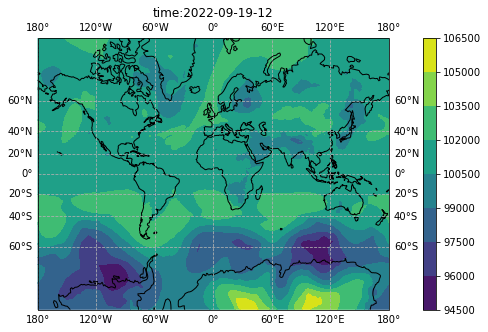

In [35]:
#proj=ccrs.PlateCarree()
proj = ccrs.Mercator(central_longitude=0, min_latitude=-80, max_latitude=80.0) # default value max_latitude=84 has error for some data
plt.gcf().set_size_inches(12, 5)
ax = plt.axes(projection=proj)
data_slice = ds[var.value]
fill = ax.contourf(lons, lats, data_slice, transform=ccrs.PlateCarree())  # lons and lats are necessary
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle='--')
ax.set_title('time:' + times)
plt.colorbar(fill)